<a href="https://colab.research.google.com/github/Shreyas911/PINN/blob/main/PINN_himalayan_mountain_glacier_fake_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchtext==0.10.0 -f https://download.pytorch.org/whl/cu111/torch_stable.html

### Import the required libraries
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_xla ## Specially for TPUs
import torch_xla.core.xla_model as xm ## Specially for TPUs

     |████████████████████████████████| 149.9 MB 25 kB/s 
     |████████████████████████████████| 57 kB 3.9 MB/s 
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.10
    Uninstalling google-api-python-client-1.12.10:
      Successfully uninstalled google-api-python-client-1.12.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.296 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 1.8.0 which is incompatible.
Looking in links: https://download.pytorch.org/whl/cu111/torch_stable.html
     |█████████████                   | 834.1 MB 1.5 MB/s eta 0:13:31tcmalloc: large alloc 1147494400 bytes == 0x55b6224d8000 @  0x7f2bbca12615 0x55b6203c53bc 0x55b6204a618a 0x55b6203c81cd 0x55b6204bab3d 0x55b62043c458 0x55b62043702f 0x55b6203c9aba 0x55b62043c2c0 0x55b

## Specify the device

We now specify the device type. There are two options to leverge the power of parallel computing. We can either use GPUs or TPUs. In this case, we use TPUs. 

In [2]:
### GPU ###
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.cuda.empty_cache()
###########

### TPU ###
device = xm.xla_device()
###########

device

device(type='xla', index=1)

In [3]:
class physics_informed_NN(nn.Module):
    
    def __init__ (self):

        super(physics_informed_NN, self).__init__()

        self.fc1 = nn.Linear(2, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 200)
        self.fc4 = nn.Linear(200, 200)
        self.fc5 = nn.Linear(200, 200)
        self.fc6 = nn.Linear(200, 200)
        self.fc7 = nn.Linear(200, 200)
        self.fc8 = nn.Linear(200, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.tanh(self.fc3(x))
        x = torch.tanh(self.fc4(x))
        # x = torch.tanh(self.fc5(x))
        # x = torch.tanh(self.fc6(x))
        # x = torch.tanh(self.fc7(x))
        x = self.fc8(x)
        return x

physics_informed_NN

__main__.physics_informed_NN

##True solution 

We now generate the true solution for a simple mountain glacier model, taken from *Fundamentals of Glacier Dynamics* by CJ van der Veen and then look to make our neural network model *emulate* this PDE. The system is modeled by a non-linear, highly diffusive PDE. Although, ice sheet models tend to be non-local, but as a starting point we assume a local model. 

$$
 \frac{\partial H}{\partial t } = -\frac{\partial}{\partial x}\left(-D(x)\frac{\partial h}{\partial x}\right) + M\\
  D(x) = CH^{n+2}\left|\frac{\partial h}{\partial x}\right|^{n-1}\\
  C = \frac{2A}{n+2}(\rho g)^n\\
    H(x,t) = h(x,t) - b(x) \\ 
    H_l = 0, H_r > 0
$$

$$\frac{\partial{b}}{\partial{x}} = -0.1\\
M(x) = M_0 - x M_1 \:\text{(accumulation rate, essentially a source term)}\\
M_0 = 4.0 \:\text{m/yr}, \:M_1 = 0.0002 \:\text{yr}^{-1}\\
\rho = 920 \:\text{kg/m}^3\\
g = 9.8 \:\text{m/s}^2\\
A = 10^{-16} \: \text{Pa}^{-3} \text{a}^{-1}\\
n = 3\\
dx = 1.0 \:\text{km}, \:L = 30 \:\text{km}\\
dt = 1 \:\text{month}, \:T = 2000 \:\text{yr}$$

$$
v_{x, \text{surface}} = \frac{2A}{n+1} \tau_d^n H \left\{ \phi + 1 \right\}
$$

The true solution will be generated using a staggered grid finite volume method on a fine, uniform grid.



In [4]:
A = 1e-16
n = 3
rho = 920.0
g = 9.2 
dx = 1.0
dt = 1./12.

def accum_rate_func(x):
    M = 0.004-0.0002*x
    return M

def basal_topology_func(x):
    #   b = 1.0 - 0.01*x 
    b = 0.03*np.sin(10*x)
    return b

def true_solution(L, T, accum_rate_func, basal_topology_func):



    nx = int(L/dx)
    nt = int(T/dt)
    x = np.linspace(0,L,nx+1)
    t = np.linspace(0,T,nt+1)

    M = accum_rate_func(x)
    b = basal_topology_func(x)

    ### (1.e3)**n factor appears since we convert g from m/s^2 to km/s^2 
    C = 2*A/(n+2) * (rho*g)**n * (1.e3)**n

    print(f"True value of C = {C}")

    h = np.zeros((nx+1,nt+1))
    H = np.zeros((nx+1,nt+1))
    h[:,0] = b
    h[0,:] = b[0]
    h[-1,:] = b[-1]

    H[:,0] = h[:,0] - b
    H[0,:] = h[0,:] - b[0]
    H[-1,:] = h[-1,:] - b[-1]

    for i in range(1,len(t)):

        D = C *((H[1:,i-1]+H[:nx,i-1])/2.0)**(n+2) * ((h[1:,i-1] - h[:nx,i-1])/dx)**(n-1)

        phi = -D*(h[1:,i-1]-h[:nx,i-1])/dx

        h[1:nx,i] = h[1:nx,i-1] + M[1:nx]*dt - dt/dx * (phi[1:]-phi[:nx-1])
        h[1:nx,i] = (h[1:nx,i] < b[1:nx]) * b[1:nx] + (h[1:nx,i] >= b[1:nx]) * h[1:nx,i]
        H[:,i] = h[:,i] - b

    alpha_sx = np.zeros((nx+1,nt+1))
    tau_d = np.zeros((nx+1,nt+1))
    alpha_sx[0, :] = (h[1, :] - h[0, :]) / dx
    alpha_sx[-1, :] = (h[-1, :] - h[-2, :]) / dx
    alpha_sx[1:-1, :] = (h[2:, :] - h[:-2, :]) / (2*dx)
    tau_d = - rho * g * H * alpha_sx
    phi = 0.0

    vx_surface= 2*A/(n+2) * (tau_d)**n * (1.e3)**n * H * (phi + 1)

    return x, t, H, h, b, vx_surface, alpha_sx, C, n

In [5]:
L = 30.
T = 400.

x, t, H_true, h_true, b_true, vx_surface_true, alpha_sx_true, C_true, n_true = true_solution(L, T, accum_rate_func, basal_topology_func)

True value of C = 24254.200053759996


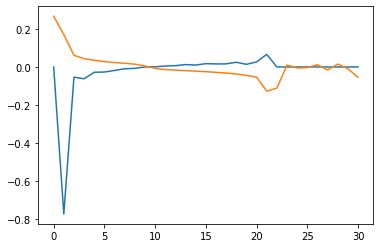

In [6]:
plt.plot(vx_surface_true[:,-1])
plt.plot(alpha_sx_true[:,-1])

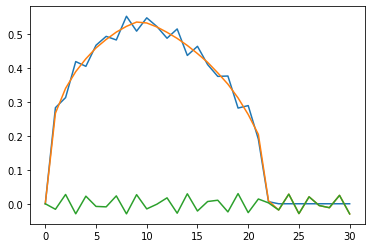

In [7]:
plt.plot(H_true[:,-1])
plt.plot(h_true[:,-1])
plt.plot(b_true)

In [8]:
alpha_sx_true[:,-1]

array([ 0.26721248,  0.17032359,  0.06135053,  0.04359092,  0.0349697 ,
        0.02848931,  0.02334943,  0.01934371,  0.01480736,  0.00495692,
       -0.00723909, -0.01378927, -0.01687869, -0.01939216, -0.02239699,
       -0.02484852, -0.0284619 , -0.03222996, -0.03695989, -0.04472289,
       -0.05376432, -0.12732021, -0.11162336,  0.00978025, -0.00531696,
       -0.00393308,  0.01191723, -0.01606574,  0.01504337, -0.0091792 ,
       -0.05479804])

## Inferring basal topography from surface velocity data and surface topography data

Since we are training our network to find the diffusion coefficient, we want to enforce the physics, as well look to fit the data. We define the Loss function as follows (superscripts indicate the data) - 


$$\text{PDE operator} \quad \mathcal{F}(x, t) = H_t (x,t) - 3 (C H^5 h_x^3)_x  - M(x) $$
$$\text{Loss function} \quad \mathcal{L} = \frac{1}{N_i}\sum_{i=1}^{N_i} \left(h^i - h(x^i,0)\right)^2 + \frac{1}{N_b}\sum_{i=1}^{N_b} \left(h^i - h(x^i, t^i)\right)^2 + \frac{1}{N_c}\sum_{i=1}^{N_c} \left(\mathcal{F}(x^i, t^i) \right)^2 + \frac{1}{N_d}\sum_{i=1}^{N_d} \left(h^i - h(x^i, t^i)\right)^2$$

where, $N_i$, $N_b$, $N_c$ are the initial value points, boundary value points and collocation points in the interior where we want the model to obey the physics.

Here, we optimize wrt both the neural network parameters as well as the unknown accumulation rate $M$. $M$ is modeled as $M=B+Ax$ and we look to infer the coeffients A and B. $B_{\text{true}} = 0.004, A_{\text{true}} = -0.0002$

In [9]:
x = x.reshape(-1,1)
t = t.reshape(-1,1)

### Initial data
Ni = 25
random_i = np.random.permutation(x.shape[0])[:Ni]
x_i = x[random_i]
t_i = np.zeros((Ni, 1))
h_i = np.reshape(h_true[random_i, 0], (-1,1))

### Boundary data
Nb = 500
Nb = int(Nb/2) # Split points to two boundaries

random_b = np.random.permutation(t.shape[0])[:Nb]
x_l = np.zeros((Nb, 1))
x_r = L*np.ones((Nb, 1))
t_b = t[random_b]
h_l = np.reshape(h_true[0, random_b], (-1,1))
h_r = np.reshape(h_true[-1, random_b], (-1,1))

### Collocation points - sample such that you don't sample the boundary and initial points again
# Nc = 75000

# x_grid = np.tile(x,(1, t.shape[0]))
# t_grid = np.tile(t.T,(x.shape[0], 1))

# temp = np.zeros((x.shape[0]-2)*(t.shape[0]-1), dtype = bool)
# temp[:Nc] = 1
# temp = np.random.permutation(temp)
# temp = np.reshape(temp, (x.shape[0]-2, t.shape[0]-1))
# random_c = np.zeros((x.shape[0], t.shape[0]), dtype = bool)
# random_c[1:-1,1:] = temp
# x_c = x_grid[random_c].reshape(-1,1)
# t_c = t_grid[random_c].reshape(-1,1)
# h_c = h_true[random_c].reshape(-1,1)


x_grid = np.tile(x,(1, t.shape[0]))
t_grid = np.tile(t.T,(x.shape[0], 1))
x_c = x_grid[:,:].reshape(-1,1)
t_c = t_grid[:,:].reshape(-1,1)
h_c = h_true[:,:].reshape(-1,1)

### Data points - sample such that you don't sample the boundary and initial points again
# Nd = 75000

# temp = np.zeros((x.shape[0]-2)*(t.shape[0]-1), dtype = bool)
# temp[:Nd] = 1
# temp = np.random.permutation(temp)
# temp = np.reshape(temp, (x.shape[0]-2, t.shape[0]-1))
# random_d = np.zeros((x.shape[0], t.shape[0]), dtype = bool)
# random_d[1:-1,1:] = temp
# x_d = x_grid[random_d].reshape(-1,1)
# t_d = t_grid[random_d].reshape(-1,1)
# h_d = h_true[random_d].reshape(-1,1)

x_d = x_grid[:,:].reshape(-1,1)
t_d = t_grid[:,:].reshape(-1,1)
h_d = h_true[:,:].reshape(-1,1)
vx_surface_d = vx_surface_true[:,:].reshape(-1,1)

In [10]:
x_torch_i = torch.from_numpy(x_i).float()
t_torch_i = torch.from_numpy(t_i).float()
h_torch_i = torch.from_numpy(h_i).float()

x_torch_l = torch.from_numpy(x_l).float()
x_torch_r = torch.from_numpy(x_r).float()
t_torch_b = torch.from_numpy(t_b).float()
h_torch_l = torch.from_numpy(h_l).float()
h_torch_r = torch.from_numpy(h_r).float()

x_torch_c = torch.from_numpy(x_c).float()
t_torch_c = torch.from_numpy(t_c).float()
h_torch_c = torch.from_numpy(h_c).float()

x_torch_d = torch.from_numpy(x_d).float()
t_torch_d = torch.from_numpy(t_d).float()
h_torch_d = torch.from_numpy(h_d).float()
vx_surface_torch_d = torch.from_numpy(vx_surface_d).float()

### Concatenate the respective x and t tensors 
X_i = torch.cat((x_torch_i, t_torch_i), 1)

X_l = torch.cat((x_torch_l, t_torch_b), 1)
X_r = torch.cat((x_torch_r, t_torch_b), 1)

X_c = torch.cat((x_torch_c, t_torch_c), 1)

X_d = torch.cat((x_torch_d, t_torch_d), 1)

In [11]:
X_i = X_i.to(device)
H_small_i = h_torch_i.to(device)

X_l = X_l.to(device)
H_small_l = h_torch_l.to(device)
X_r = X_r.to(device)
H_small_r = h_torch_r.to(device)

X_c = X_c.to(device)
H_small_c = h_torch_c.to(device)

X_d = X_d.to(device)
H_small_d = h_torch_d.to(device)
### 'small' makes no sense for this variable name, but we just go along with it
vx_surface_small_d = vx_surface_torch_d.to(device)

In [12]:
X_d.shape[0]

148831

In [13]:
X_c.shape

torch.Size([148831, 2])

In [ ]:
PINN = physics_informed_NN()
PINN.to(device)

optimizer = torch.optim.Adam(PINN.parameters(), lr=0.0001)
criterion = nn.MSELoss()
my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=0.995)
# my_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
#C = torch.tensor(0., requires_grad = True)

# M = torch.zeros((Nc), requires_grad = True, dtype = float, device = device)
# A = torch.tensor(0., requires_grad = True, device = device)
# B = torch.tensor(0., requires_grad = True, device = device)
# optimizer.add_param_group({'params': A})
# optimizer.add_param_group({'params': B})

b = torch.ones((int(L/dx)+1,1), requires_grad = True, device = device)
optimizer.add_param_group({'params': b, 'lr':5.e-2})
b.shape

In [ ]:
statistics = []
for epochs in range(2000):

    X_c_clone = X_c.clone()
    X_c_index = X_c[:,0]/dx
    X_c_index = X_c_index.to(torch.int64)
    X_c_clone.requires_grad = True
    h_pred = PINN(X_c_clone)

    # b = 1.0 - 0.01*X_c_clone[:,0]
    # b = torch.reshape(b, (-1,1))
    M = 0.004-0.0002*X_c_clone[:,0]

    H_pred = torch.sub(h_pred, b[X_c_index])
    gradients_h = torch.autograd.grad(torch.sum(h_pred), X_c_clone, create_graph=True)
    h_x = gradients_h[0][:,0]
    h_t = gradients_h[0][:,1]
    hessians_h = torch.autograd.grad(torch.sum(h_x), X_c_clone, create_graph=True)
    h_xx = hessians_h[0][:,0]

    gradients_H = torch.autograd.grad(torch.sum(H_pred), X_c_clone, create_graph=True)
    H_x = gradients_H[0][:,0]

    flux = - C_true * torch.pow(torch.squeeze(H_pred), 5) * torch.pow(torch.abs(h_x), 2) * h_x
    gradients_flux = torch.autograd.grad(torch.sum(flux), X_c_clone, create_graph=True)
    flux_x = - gradients_flux[0][:,0]
    # M = B + A*X_c_clone[:, 0]
    pde_rhs = M + flux_x


    collocation_mse = criterion(h_t, pde_rhs)

    initial_mse = criterion(PINN(X_i), H_small_i)
    left_mse = criterion(PINN(X_l), H_small_l)
    right_mse = criterion(PINN(X_r), H_small_r)
    data_h_mse = criterion(PINN(X_d), H_small_d)

    X_d_clone = X_d.clone()
    X_d_index = X_d[:,0]/dx
    X_d_index = X_d_index.to(torch.int64)
    X_d_clone.requires_grad = True
    h_pred_for_vx = PINN(X_d_clone)

    alpha_pred_for_vx = torch.autograd.grad(torch.sum(h_pred_for_vx), X_d_clone, create_graph=True)

    tau_d = - rho * g * torch.squeeze(torch.sub(h_pred_for_vx, b[X_d_index])) * alpha_pred_for_vx[0][:,0]
    phi = 0.0
    vx_surface_pred = 2*A/(n+2) * (tau_d)**n * (1.e3)**n * torch.squeeze(torch.sub(h_pred_for_vx,b[X_d_index])) * (phi + 1)
    data_vx_mse = criterion(vx_surface_pred, torch.squeeze(vx_surface_small_d))

    loss = right_mse + left_mse + initial_mse + 40*collocation_mse + 40*data_h_mse + 20*data_vx_mse

    optimizer.zero_grad()  
    loss.backward()       
    xm.optimizer_step(optimizer)
    xm.mark_step()
    # optimizer.step()
    my_lr_scheduler.step()

    if (epochs % 5 == 0):
        statistics.append([epochs, loss.cpu().data.numpy(), left_mse.cpu().data.numpy(), right_mse.cpu().data.numpy(), initial_mse.cpu().data.numpy(), collocation_mse.cpu().data.numpy(), data_h_mse.cpu().data.numpy()])
        print (f'epoch = {epochs:.1e}, loss = {loss:.1e}, L2_error_b = {np.linalg.norm(b.cpu().data.numpy()-b_true):.1e}, lr = {my_lr_scheduler.get_last_lr()}, l_loss = {left_mse}, r_loss = {right_mse}, i_mse = {initial_mse}, c_mse = {collocation_mse}, d_mse = {data_h_mse}')

In [18]:
b

tensor([[ 0.1766],
        [ 0.5475],
        [ 0.1022],
        [ 0.1067],
        [ 0.1232],
        [ 0.0669],
        [ 0.1264],
        [ 0.1731],
        [ 0.1510],
        [ 0.3396],
        [ 0.4133],
        [ 0.4217],
        [ 0.4179],
        [ 0.4598],
        [ 0.4252],
        [ 0.4714],
        [ 0.4617],
        [ 0.4565],
        [ 0.5028],
        [ 0.5218],
        [ 0.4799],
        [-0.0232],
        [ 0.2653],
        [ 0.2663],
        [ 0.2632],
        [ 0.2670],
        [ 0.2869],
        [ 0.3044],
        [ 0.3078],
        [ 0.3087],
        [ 0.3087]], device='xla:1', requires_grad=True)

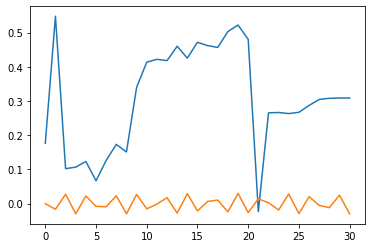

In [19]:
plt.plot(b.cpu().data.numpy())
plt.plot(b_true)

In [14]:
PINN = physics_informed_NN()
PINN.to(device)

optimizer = torch.optim.Adam(PINN.parameters(), lr=0.0001)
criterion = nn.MSELoss()
my_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=1, gamma=0.995)
# my_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
#C = torch.tensor(0., requires_grad = True)

# M = torch.zeros((Nc), requires_grad = True, dtype = float, device = device)
A = torch.tensor(0., requires_grad = True, device = device)
B = torch.tensor(0., requires_grad = True, device = device)
optimizer.add_param_group({'params': A})
optimizer.add_param_group({'params': B})

# b = torch.ones((int(L/dx)+1,1), requires_grad = True, device = device)
# optimizer.add_param_group({'params': b, 'lr':5.e-2})
# b.shape

In [15]:
statistics = []
for epochs in range(2000):

    X_c_clone = X_c.clone()
    X_c_index = X_c[:,0]/dx
    X_c_index = X_c_index.to(torch.int64)
    X_c_clone.requires_grad = True
    h_pred = PINN(X_c_clone)

    # b = 1.0 - 0.01*X_c_clone[:,0]
    # b = torch.reshape(b, (-1,1))
    M = 0.004-0.0002*X_c_clone[:,0]
    b = A* torch.sin(B*X_c_clone[:,0])

    H_pred = torch.sub(h_pred, b[X_c_index])
    gradients_h = torch.autograd.grad(torch.sum(h_pred), X_c_clone, create_graph=True)
    h_x = gradients_h[0][:,0]
    h_t = gradients_h[0][:,1]
    hessians_h = torch.autograd.grad(torch.sum(h_x), X_c_clone, create_graph=True)
    h_xx = hessians_h[0][:,0]

    gradients_H = torch.autograd.grad(torch.sum(H_pred), X_c_clone, create_graph=True)
    H_x = gradients_H[0][:,0]

    flux = - C_true * torch.pow(torch.squeeze(H_pred), 5) * torch.pow(torch.abs(h_x), 2) * h_x
    gradients_flux = torch.autograd.grad(torch.sum(flux), X_c_clone, create_graph=True)
    flux_x = - gradients_flux[0][:,0]
    # M = B + A*X_c_clone[:, 0]
    pde_rhs = M + flux_x


    collocation_mse = criterion(h_t, pde_rhs)

    initial_mse = criterion(PINN(X_i), H_small_i)
    left_mse = criterion(PINN(X_l), H_small_l)
    right_mse = criterion(PINN(X_r), H_small_r)
    data_h_mse = criterion(PINN(X_d), H_small_d)

    X_d_clone = X_d.clone()
    X_d_index = X_d[:,0]/dx
    X_d_index = X_d_index.to(torch.int64)
    X_d_clone.requires_grad = True
    h_pred_for_vx = PINN(X_d_clone)

    alpha_pred_for_vx = torch.autograd.grad(torch.sum(h_pred_for_vx), X_d_clone, create_graph=True)

    tau_d = - rho * g * torch.squeeze(torch.sub(h_pred_for_vx, b[X_d_index])) * alpha_pred_for_vx[0][:,0]
    phi = 0.0
    vx_surface_pred = 2*A/(n+2) * (tau_d)**n * (1.e3)**n * torch.squeeze(torch.sub(h_pred_for_vx,b[X_d_index])) * (phi + 1)
    data_vx_mse = criterion(vx_surface_pred, torch.squeeze(vx_surface_small_d))

    loss = right_mse + left_mse + initial_mse + 40*collocation_mse + 40*data_h_mse + 20*data_vx_mse

    optimizer.zero_grad()  
    loss.backward()       
    xm.optimizer_step(optimizer)
    xm.mark_step()
    # optimizer.step()
    my_lr_scheduler.step()

    if (epochs % 5 == 0):
        statistics.append([epochs, loss.cpu().data.numpy(), left_mse.cpu().data.numpy(), right_mse.cpu().data.numpy(), initial_mse.cpu().data.numpy(), collocation_mse.cpu().data.numpy(), data_h_mse.cpu().data.numpy()])
        print (f'epoch = {epochs:.1e}, loss = {loss:.1e}, A = {A.cpu().data.numpy():.1e}, B = {B.cpu().data.numpy():.1e}, lr = {my_lr_scheduler.get_last_lr()}, l_loss = {left_mse}, r_loss = {right_mse}, i_mse = {initial_mse}, c_mse = {collocation_mse}, d_mse = {data_h_mse}')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([148831])) that is different to the input size (torch.Size([148831, 148831])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [ ]:
b.shape